## Writing Initial Conditions with SODA

This is adapted from - https://github.com/ESMG/PyCNAL_regridding/blob/master/examples/notebooks/Creating_Initial_and_Boundary_conditions_from_SODA3.ipynb

**Required Python Package** - `PyCNAL_regridding` - https://github.com/ESMG/PyCNAL_regridding

To install:

1) `git clone https://github.com/ESMG/PyCNAL_regridding.git`
2) `cd PyCNAL_regridding`
3) `python -m pip install .`

In [34]:
from PyCNAL_regridding import *
import xarray as xr

# ---------- path to MOM6 grid and SODA3 data ---------------------
momgrd = '/Users/james/Documents/Github/esm_lab/obc_ic/natlGrid/natl_ocean_hgrid.nc'

# change this to wherever you've got SODA3
sodadir = '/Users/james/Documents/Github/esm_lab/obc_ic/sodaFiles/'

# output directory
outputdir = '/Users/james/Documents/Github/esm_lab/obc_ic/output/'

# choose soda file supplying initial conditions
sodaic = sodadir + 'soda3.3.1_5dy_ocean_reg_1992_01_05.nc'
ds = xr.open_dataset(momgrd)

In [35]:
# ---------- define a domain target on MOM grid ---------------------
Nx=int(ds.nx.shape[0])
Ny=int(ds.ny.shape[0])
domain = obc_segment('domain', momgrd,istart=0,iend=Nx,jstart=0,  jend=Ny)

In [36]:
# ---------- define variables on each segment ------------------
temp_domain = obc_variable(domain,'temp',geometry='surface',obctype='radiation')
salt_domain = obc_variable(domain,'salt',geometry='surface',obctype='radiation')
ssh_domain  = obc_variable(domain,'ssh' ,geometry='line'   ,obctype='flather')
vel_domain  = obc_vectvariable(domain,'u','v',geometry='surface',obctype='radiation')

In [38]:
# ---------- interpolate T/S/U/V/SSH from SODA file -------------------
# note that since temp/salt/ssh are on all defined on T-point, we can re-use
# the same interpolator (time-saving)

interp_t2s = temp_domain.interpolate_from(sodaic,'temp',frame=0,depthname='st_ocean', \
                                          coord_names=['xt_ocean','yt_ocean'],method='bilinear')
salt_domain.interpolate_from(sodaic,'salt',frame=0,depthname='st_ocean',coord_names=['xt_ocean','yt_ocean'],\
                             method='bilinear',interpolator=interp_t2s)
ssh_domain.interpolate_from(sodaic ,'ssh' ,frame=0,coord_names=['xt_ocean','yt_ocean'],\
                            method='bilinear',interpolator=interp_t2s)

# but we can't reuse the previous interpolator because u,v are defined at U,V point, not T point
interp_u2s, interp_v2s = vel_domain.interpolate_from(sodaic,'u','v',frame=0,depthname='st_ocean',\
                                                     coord_names_u=['xu_ocean','yu_ocean'], \
                                                     coord_names_v=['xu_ocean','yu_ocean'],method='bilinear')

Subset source grid : full dimension is  720 330  subset is  512 113 92 284
drown


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
# ---------- list segments and variables to be written -------
list_segments = [domain]
list_variables = [ssh_domain,temp_domain,salt_domain]
list_vectvariables = [vel_domain]

#----------- time --------------------------------------------
# I think this should be adjusted as defining time in this way creates problems with the netcdf file when loading in xarray, but for now I'll leave it
time = temp_domain.timesrc

# ---------- write to file -----------------------------------
write_ic_file(list_segments,list_variables,list_vectvariables,time,output=outputdir + 'initial_condition_natl_1992_SODA3.12.2.nc')

In [24]:
# this is how you have to load this because of the timing issue
ic = xr.open_dataset("initial_condition_SODA3.nc", decode_times=False)
#ic.temp[0][0].plot()

# Create OBC files using SODA-based boundary conditions


In [8]:
import xarray as xr
import xesmf
import matplotlib.pyplot as plt
import bottleneck
import numpy as np
import subprocess as sp
import os
import glob
import cartopy.crs as ccrs

This example uses monthly output from SODA reanalysis in order to generate boundary conditions for a Northwest Atlantic configuration. Ocean current vectors from a staggered C-grid are co-located at q-points (corners). The grid rotation angles contained in the SODA supergrid files are used to align the currents with the target regional grid.

## Step 1: Open parent and regional model grids

In [9]:
sodafile = '/Users/james/Documents/Github/esm_lab/obc_ic/sodaFiles/soda3.12.2_5dy_ocean_reg_1993_01_04.nc'
hgrid_file = '/Users/james/Documents/Github/esm_lab/obc_ic/nwaGrid/nwa_ocean_hgrid.nc'
path_parent_grid='/Users/james/Documents/Github/esm_lab/obc_ic/sodaFiles/SODA3_0.5deg_grid.nc'

def open_grid(path,decode_times=False):
    """Return a grid object containing staggered grid locations"""
    grid={}
    grid['ds']=xr.open_dataset(path,decode_times=False)
    grid['ds']=grid['ds'].drop_dims(['ny','nx'])
    grid['ds']=grid['ds'].drop_vars(['tile'])
    
    # ! added conversion of angle to degrees
    grid['ds']['angle_dx'] = np.degrees(grid['ds']['angle_dx'])
    
    grid['nyp']=grid['ds'].nyp.data[-1]+1
    grid['nxp']=grid['ds'].nxp.data[-1]+1
    nxp=grid['nxp'];nyp=grid['nyp']
    grid['h'] = grid['ds'].isel(nxp=slice(1,nxp+1,2),nyp=slice(1,nyp+1,2))
    #The q grid is not symmetric, but Cu and Cv are
    grid['q'] = grid['ds'].isel(nxp=slice(2,nxp+1,2),nyp=slice(2,nyp+1,2))
    grid['Cu'] = grid['ds'].isel(nxp=slice(0,nxp+1,2),nyp=slice(1,nyp+1,2))
    grid['Cv'] = grid['ds'].isel(nxp=slice(1,nxp+1,2),nyp=slice(0,nyp+1,2))
    return grid

def open_soda_supergrid(path,decode_times=False):
    """Return a grid object containing staggered grid locations"""
    grid={}
    grid['ds']=xr.open_dataset(path,decode_times=False)

    grid['ds']=grid['ds'].drop_dims(['yt_ocean','xt_ocean'])
    grid['nyp']=grid['ds'].yu_ocean.data[-1]+1
    grid['nxp']=grid['ds'].xu_ocean.data[-1]+1
    nxp=grid['nxp'];nyp=grid['nyp']
    grid['h'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1),yu_ocean=slice(0,nyp+1))
    #The q grid is not symmetric, but Cu and Cv are
    grid['q'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1),yu_ocean=slice(0,nyp+1))
    grid['Cu'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1),yu_ocean=slice(0,nyp+1))
    grid['Cv'] = grid['ds'].isel(xu_ocean=slice(0,nxp+1),yu_ocean=slice(0,nyp+1))
    return grid

regional_grid = open_grid(hgrid_file)
soda = xr.open_dataset(sodafile)
parent_grid=open_soda_supergrid(path_parent_grid)

In [10]:
soda_u = (
    soda[['u', 'v', 'yu_ocean', 'xu_ocean', 'st_ocean']]
    .rename({'yu_ocean': 'lat', 'xu_ocean': 'lon', 'st_ocean': 'z'})
)

coords = xr.Dataset({
    'lon': regional_grid['ds']['x'].isel(nyp=0),
    'lat': regional_grid['ds']['y'].isel(nyp=0),
    'angle': regional_grid['ds']['angle_dx'].isel(nyp=0)
})

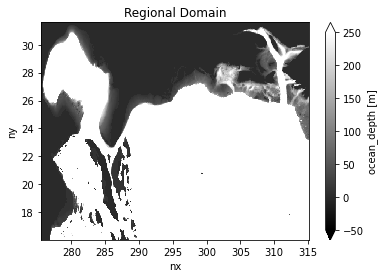

In [12]:
dsr_topo=xr.open_dataset('/Users/james/Documents/Github/esm_lab/obc_ic/nwaGrid/ocean_topog_etopo_unsmoothed_v3.nc')
#dsr_topo = xr.merge([dsr_topo, regional_grid['h']])
dsr_topo.depth.plot(vmax=-50.,vmin=250.,cmap='gist_gray')
txt=plt.title('Regional Domain')

## Step 2: Open parent model data and merge respective grids

In [13]:
def open_dataset(path,fields,grid):
    ds=xr.open_dataset(path,decode_times=False)
    tracer_list=[];uv_list=[]
    for f in fields:
        for fnam,val in zip(f.keys(),f.values()):
            if val=='h':tracer_list.append(fnam)
            if val=='Cu':uv_list.append(fnam)
            if val=='Cv':uv_list.append(fnam)
                
    ds_tr = xr.merge([ds, grid['h']])
    ds_u= xr.merge([ds,grid['Cu']])
    ds_v= xr.merge([ds,grid['Cv']])
    return {'ds_tr':ds_tr,'ds_u':ds_u,'ds_v':ds_v,'tracers':tracer_list,'uv':uv_list}

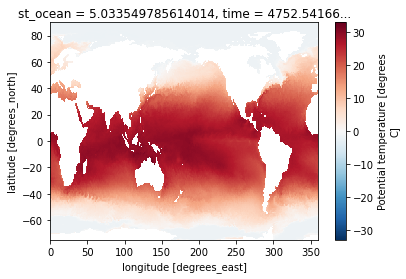

In [14]:
# load the model data
path_model_data='/Users/james/Documents/Github/esm_lab/obc_ic/sodaFiles/soda3.12.2_5dy_ocean_reg_1993_01_04.nc'

fields=[{'temp':'h'},{'salt':'h'},{'ssh':'h'},{'u':'Cu'},{'v':'Cv'}]
model_data = open_dataset(path_model_data,fields,parent_grid)
model_data['ds_u'].temp[0][0].plot()

## Step 4: Define boundaries for regional domain model

In [15]:
ds_regional=regional_grid['ds']

# southern boundary
south = xr.Dataset()
south['lon'] = ds_regional['x'].isel(nyp=0)
south['lat'] = ds_regional['y'].isel(nyp=0)
# eastern boundary
east = xr.Dataset()
east['lon'] = ds_regional['x'].isel(nxp=-1)
east['lat'] = ds_regional['y'].isel(nxp=-1)

In [16]:
#Load tracers
ds_tr=model_data['ds_tr']
ds_tr = xr.Dataset({'temp':ds_tr.temp,'salt':ds_tr.salt},coords={'lon':ds_tr.geolon_c,'lat':ds_tr.geolat_c})

## Step 5: Calculate remapping weights

For the NWA domain, we only have South and East open boundaries. Therefore, we only calculate these.

In [17]:
#Using nearest neighbor - other options could be used here , e.g. bilinear.
regrid_south_uv = xesmf.Regridder(soda_u[['u', 'v']], south, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_south_uv.nc')
regrid_east_uv = xesmf.Regridder(soda_u[['u', 'v']], east, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_east_uv.nc')

regrid_south_tr = xesmf.Regridder(ds_tr, south, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_south_tr.nc')
regrid_east_tr = xesmf.Regridder(ds_tr, east, 'nearest_s2d', 
                               locstream_out=True, periodic=False, filename='regrid_east_tr.nc')

## Step 6: Remap potential temperature,salinity,currents and SSH to boundaries

In [18]:
def apply_rotation_transpose(ue,vn,angle_dx,time_slice=slice(0)):
    """Rotate from easterly coordinates to model space"""
    deg_rad=np.pi/180.
    
    if time_slice is not None:
        t=ue.time.isel(time=time_slice)
    else:
        t=ue.time

    if time_slice is not None:
        u=np.cos(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.sin(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
        v=-np.sin(angle_dx.data*deg_rad)*ue.isel(time=time_slice).data+np.cos(angle_dx.data*deg_rad)*vn.isel(time=time_slice).data
    else:
        u=np.cos(angle_dx.data*deg_rad)*ue.data+np.sin(angle_dx.data*deg_rad)*vn.data
        v=-np.sin(angle_dx.data*deg_rad)*ue.data+np.cos(angle_dx.data*deg_rad)*vn.data
    nyp=u.shape[2]
      
    u=xr.DataArray(u,coords={'i':np.arange(1,nyp+1),'time':t,'z_l':ue.z_l},dims=('time','z_l','i'))
    v=xr.DataArray(v,coords={'i':np.arange(1,nyp+1),'time':t,'z_l':ue.z_l},dims=('time','z_l','i'))
    
    return u,v


In [19]:
u_south_r = regrid_south_uv(soda_u['u']).rename({'z': 'z_l'})
v_south_r = regrid_south_uv(soda_u['v']).rename({'z': 'z_l'})
u_east_r = regrid_east_uv(soda_u['u']).rename({'z': 'z_l'})
v_east_r = regrid_east_uv(soda_u['v']).rename({'z': 'z_l'})


/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [20]:

u_south,v_south=apply_rotation_transpose(u_south_r,v_south_r,ds_regional.angle_dx.isel(nyp=ds_regional.nyp[0]),time_slice=None)
u_south['z_l'] = np.arange(len(u_south['z_l']))
v_south['z_l'] = np.arange(len(v_south['z_l']))

ds_uv_south = xr.Dataset({'u':u_south.ffill(dim='i',limit=None).ffill(dim='z_l').fillna(0.),'v':v_south.ffill(dim='i',limit=None).ffill(dim='z_l').fillna(0.)},coords={'lon':south.lon,'lat':south.lat,'z_l':u_south.z_l})
fnam='uv_south.nc'
ds_uv_south.time.encoding['calendar']='gregorian'
ds_uv_south.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

u_east,v_east=apply_rotation_transpose(u_east_r,v_east_r,ds_regional.angle_dx.isel(nxp=ds_regional.nxp[-1]),time_slice=None)
u_east['z_l'] = np.arange(len(u_east['z_l']))
v_east['z_l'] = np.arange(len(v_east['z_l']))


ds_uv_east = xr.Dataset({'u':u_east.ffill(dim='i',limit=None).ffill(dim='z_l').fillna(0.),'v':v_east.ffill(dim='i',limit=None).ffill(dim='z_l').fillna(0.)},coords={'lon':east.lon,'lat':east.lat,'st_ocean':u_south.z_l})
fnam='uv_east.nc'
ds_uv_east.time.encoding['calendar']='gregorian'
ds_uv_east.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

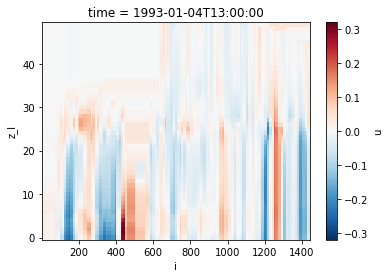

In [21]:
ds_uv_south.u.isel(time=0).plot()

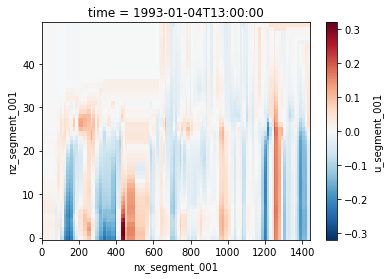

In [22]:
an = xr.open_dataset("/Users/james/Documents/Github/esm_lab/obc_ic/andrew/uv_001_1993.nc")
an.u_segment_001.isel(ny_segment_001=0, time=0).plot()


In [23]:
temp_south = regrid_south_tr(ds_tr['temp'])
salt_south = regrid_south_tr(ds_tr['salt'])
ds_tr_south = xr.Dataset({'temp':temp_south,'salt':salt_south})
ds_tr_south.time.attrs['calendar']='gregorian'
fnam='tracers_south.nc'
ds_tr_south.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

temp_east = regrid_east_tr(ds_tr['temp'])
salt_east = regrid_east_tr(ds_tr['salt'])
ds_tr_east = xr.Dataset({'temp':temp_east,'salt':salt_east})
ds_tr_east.time.attrs['calendar']='gregorian'
fnam='tracers_east.nc'
ds_tr_east.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable temp as the horizontal dimensions for the regridding.
  warnings.warn(
/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable salt as the horizontal dimensions for the regridding.
  warnings.warn(


In [24]:
ds_ssh=model_data['ds_tr']
ds_ssh = xr.Dataset({'ssh':ds_ssh.ssh},coords={'lon':ds_ssh.geolon_c,'lat':ds_ssh.geolat_c})

ssh_south = regrid_south_tr(ds_ssh['ssh'])
ds_ssh_south = xr.Dataset({'ssh':ssh_south})
ds_ssh_south.time.attrs['calendar']='gregorian'
fnam='ssh_south.nc'
ds_ssh_south.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

ssh_east = regrid_east_tr(ds_ssh['ssh'])
ds_ssh_east = xr.Dataset({'ssh':ssh_east})
ds_ssh_east.time.attrs['calendar']='gregorian'
fnam='ssh_east.nc'
ds_ssh_east.to_netcdf(fnam,unlimited_dims='time',format='NETCDF3_CLASSIC')

/Users/james/opt/anaconda3/envs/gridTools/lib/python3.9/site-packages/xesmf/frontend.py:531: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable ssh as the horizontal dimensions for the regridding.
  warnings.warn(


## Step 7: Inspect the output

(50.0, 0.0)

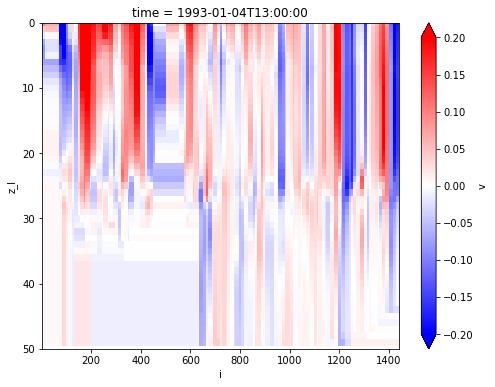

In [25]:
fig=ds_uv_south.v.isel(time=0).plot(figsize=[8, 6], yincrease=False, vmin=-.2,vmax=.2 ,cmap='bwr')
plt.ylim(50,0)

Text(0.5, 1.0, 'Eastern Boundary temperature')

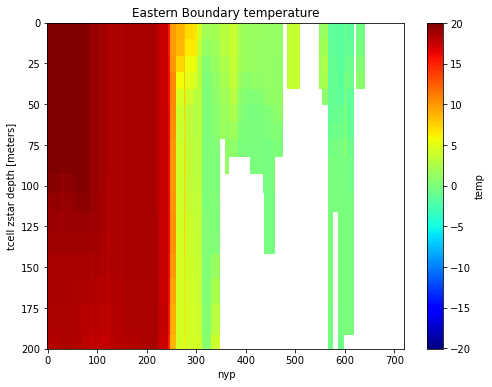

In [26]:
fig=ds_tr_east.temp.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')
plt.ylim(200,0)
plt.title('Eastern Boundary temperature')

In [27]:
params=[]
params.append({'suffix':'_segment_001','dim0':2,'tr_in':'tracers_south.nc','tr_out':'obc_ts_south.nc','uv_in':'uv_south.nc','uv_out':'obc_uv_south.nc','ssh_in':'ssh_south.nc','ssh_out':'obc_ssh_south.nc'})
params.append({'suffix':'_segment_002','dim0':2,'tr_in':'tracers_east.nc','tr_out':'obc_ts_east.nc','uv_in':'uv_east.nc','uv_out':'obc_uv_east.nc','ssh_in':'ssh_east.nc','ssh_out':'obc_ssh_east.nc'})

for pr in params:
    ds=xr.open_dataset(pr['tr_in'],decode_times=False)


## Step 8: Finally some reformatting for MOM6

SODA data has different naming conventions than OM4, so we still have some `st_ocean` variable names in here.

In [28]:
params=[]
params.append({'suffix':'_segment_001','dim0':2,'tr_in':'tracers_south.nc','tr_out':'obc_ts_south.nc','uv_in':'uv_south.nc','uv_out':'obc_uv_south.nc','ssh_in':'ssh_south.nc','ssh_out':'obc_ssh_south.nc'})
params.append({'suffix':'_segment_002','dim0':2,'tr_in':'tracers_east.nc','tr_out':'obc_ts_east.nc','uv_in':'uv_east.nc','uv_out':'obc_uv_east.nc','ssh_in':'ssh_east.nc','ssh_out':'obc_ssh_east.nc'})

for pr in params:
    ds=xr.open_dataset(pr['tr_in'],decode_times=False)
    zl=ds.temp.st_ocean
    zi=0.5*(np.roll(zl,shift=-1)+zl)
    zi[-1]=6500.
    ds['z_i']=zi
    dz=zi-np.roll(zi,shift=1)
    dz[0]=zi[0]
    ds['dz']=dz
    nt=ds.time.shape[0]
    nx=ds.lon.shape[0]
    dz=np.tile(ds.dz.data[np.newaxis,:,np.newaxis],(nt,1,nx))
    da_dz=xr.DataArray(dz,coords=[('time',ds.time),('z_l',ds.z_i),('locations',ds.lon)])
    da_dz=da_dz.expand_dims('dim_0',pr['dim0'])
    ds.time.attrs['modulo']=' '
    try:
        da_temp=xr.DataArray(ds.temp.ffill(dim='nxp',limit=None).ffill(dim='st_ocean').fillna(0.))
    except:
        da_temp=xr.DataArray(ds.temp.ffill(dim='nyp',limit=None).ffill(dim='st_ocean').fillna(0.))
    da_temp=da_temp.expand_dims('dim_0',pr['dim0'])
    try:
        da_salt=xr.DataArray(ds.salt.ffill(dim='nxp',limit=None).ffill(dim='st_ocean').fillna(0.))
    except:
        da_salt=xr.DataArray(ds.salt.ffill(dim='nyp',limit=None).ffill(dim='st_ocean').fillna(0.))
    da_salt=da_salt.expand_dims('dim_0',pr['dim0'])
    ds_=xr.Dataset({'temp'+pr['suffix']:da_temp,'salt'+pr['suffix']:da_salt,'lon':ds.lon,'lat':ds.lat,'dz_temp'+pr['suffix']:da_dz,'dz_salt'+pr['suffix']:da_dz})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20    
    ds_.to_netcdf(pr['tr_out'],unlimited_dims=('time'))
    ds=xr.open_dataset(pr['uv_in'],decode_times=False)
    ds.time.attrs['modulo']=' '
    da_u=xr.DataArray(ds.u.ffill(dim='i',limit=None).ffill(dim='z_l').fillna(0.))
    da_u=da_u.expand_dims('dim_0',pr['dim0'])
    da_v=xr.DataArray(ds.v.ffill(dim='i',limit=None).ffill(dim='z_l').fillna(0.))
    da_v=da_v.expand_dims('dim_0',pr['dim0'])
    ds_=xr.Dataset({'u'+pr['suffix']:da_u,'v'+pr['suffix']:da_v,'lon':ds.lon,'lat':ds.lat,'dz_u'+pr['suffix']:da_dz,'dz_v'+pr['suffix']:da_dz})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20    
    ds_.to_netcdf(pr['uv_out'],unlimited_dims=('time'))
    ds=xr.open_dataset(pr['ssh_in'],decode_times=False)
    ds.time.attrs['modulo']=' '
    try:
        da_ssh=xr.DataArray(ds.ssh.ffill(dim='nyp',limit=None).fillna(0.))
    except:
        da_ssh=xr.DataArray(ds.ssh.ffill(dim='nxp',limit=None).fillna(0.))
    da_ssh=da_ssh.expand_dims('dim_0',pr['dim0']-1)
    ds_=xr.Dataset({'ssh'+pr['suffix']:da_ssh,'lon':ds.lon,'lat':ds.lat})
    for v in ds_:
        ds_[v].encoding['_FillValue']=1.e20    
    ds_.to_netcdf(pr['ssh_out'],unlimited_dims=('time'))

<ipython-input-28-47dd40ea3593>:43: SerializationWarning: saving variable z_l with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_.to_netcdf(pr['uv_out'],unlimited_dims=('time'))
<ipython-input-28-47dd40ea3593>:43: SerializationWarning: saving variable z_l with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_.to_netcdf(pr['uv_out'],unlimited_dims=('time'))
<ipython-input-28-47dd40ea3593>:43: SerializationWarning: saving variable st_ocean with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_.to_netcdf(pr['uv_out'],unlimited_dims=('time'))


Text(0.5, 1.0, 'Andrew 1993 OBC U-South')

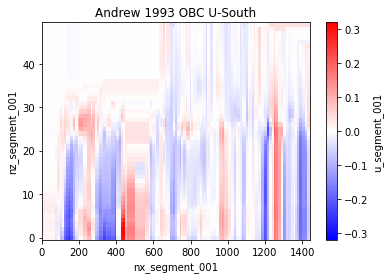

In [29]:
import matplotlib.pyplot as plt
import xarray as xr

an = xr.open_dataset("/Users/james/Documents/Github/esm_lab/obc_ic/andrew/uv_001_1993.nc")
nwa = xr.open_dataset("/Users/james/Documents/Github/esm_lab/obc_ic/obc_uv_south.nc")

an.u_segment_001.isel(ny_segment_001=0, time=0).plot(cmap='bwr')
plt.title("Andrew 1993 OBC U-South")

In [31]:
nwa

<xarray.Dataset>
Dimensions:           (dim_0: 1, i: 1441, locations: 1441, nxp: 1441, time: 1, z_l: 100)
Coordinates:
  * z_l               (z_l) int32 0 1 2 3 4 5 ... 4451 4660 4870 5080 5290 6500
  * i                 (i) int32 1 2 3 4 5 6 7 ... 1436 1437 1438 1439 1440 1441
  * time              (time) datetime64[ns] 1993-01-04T13:00:00
    lat               (nxp) float32 ...
    lon               (nxp) float32 ...
  * locations         (locations) float32 275.5 275.6 275.6 ... 315.1 315.1
Dimensions without coordinates: dim_0, nxp
Data variables:
    u_segment_001     (time, z_l, dim_0, i) float64 ...
    v_segment_001     (time, z_l, dim_0, i) float64 ...
    dz_u_segment_001  (time, z_l, dim_0, locations) float64 ...
    dz_v_segment_001  (time, z_l, dim_0, locations) float64 ...

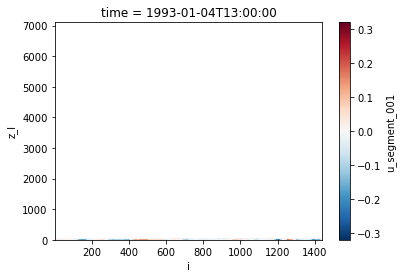

In [32]:
nwa.u_segment_001.isel(time=0, dim_0=0).plot()